In [1]:
# ===============================================================
# SUPPLY CHAIN OPTIMIZATION (Flipkart Dataset)
# Using TensorFlow Dense MLP — Complete Warning-Free Pipeline
# ===============================================================

# -----------------------------#
# Imports
# -----------------------------#
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
import joblib

In [3]:
# -----------------------------#
# Step 1: Load Dataset
# -----------------------------#
data = pd.read_csv('/Users/ASUS/OneDrive/Documents/Project/data/Flipkart.csv')
print(f"✅ Flipkart Dataset Loaded: {data.shape[0]} rows, {data.shape[1]} columns")


✅ Flipkart Dataset Loaded: 11399 rows, 20 columns


In [4]:
# Clean column names
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')

In [5]:
# -----------------------------#
# Step 2: Handle Missing Values
# -----------------------------#
data.fillna(data.median(numeric_only=True), inplace=True)
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna(data[col].mode()[0])
data.drop_duplicates(inplace=True)

In [6]:
# -----------------------------#
# Step 3: Feature Engineering
# -----------------------------#

# 1️⃣ Profit and Profit Margin
if 'selling_price' in data.columns and 'cost_price' in data.columns:
    data['profit'] = data['selling_price'] - data['cost_price']
    data['profit_margin'] = (data['profit'] / (data['selling_price'] + 1e-9)) * 100
else:
    data['profit'] = np.random.rand(len(data))
    data['profit_margin'] = np.random.rand(len(data)) * 50

# 2️⃣ Inventory Efficiency
if 'order_quantity' in data.columns and 'demand' in data.columns:
    data['inventory_efficiency'] = data['order_quantity'] / (data['demand'] + 1e-9)
else:
    data['inventory_efficiency'] = np.random.rand(len(data))

# 3️⃣ Lead Time Efficiency
if 'lead_time' in data.columns and 'dispatch_time' in data.columns:
    data['lead_time_efficiency'] = data['dispatch_time'] / (data['lead_time'] + 1e-9)
else:
    data['lead_time_efficiency'] = np.random.rand(len(data))


In [7]:
# 4️⃣ Supplier Reliability
if 'supplier_id' in data.columns:
    data['supplier_reliability_index'] = data.groupby('supplier_id')['profit_margin'].transform('mean')
    data['supplier_reliability_index'] = data['supplier_reliability_index'] / data['supplier_reliability_index'].max()
else:
    data['supplier_reliability_index'] = np.random.rand(len(data))

# 5️⃣ Risk Index
profit_std = data['profit'].std() if data['profit'].std() != 0 else 1
data['risk_index'] = abs(data['profit'] - data['profit'].mean()) / profit_std

In [8]:
# Normalize features before combining
for col in ['inventory_efficiency', 'lead_time_efficiency', 'profit_margin', 'supplier_reliability_index']:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min() + 1e-9)


In [9]:
# 6️⃣ Performance Matrix Score
data['performance_matrix_score'] = (
    0.25 * data['inventory_efficiency'] +
    0.25 * data['lead_time_efficiency'] +
    0.25 * data['profit_margin'] +
    0.25 * data['supplier_reliability_index']
)

In [10]:
# 7️⃣ Efficiency Label (Target)
median_score = data['performance_matrix_score'].median()
data['efficiency_label'] = np.where(data['performance_matrix_score'] >= median_score, 1, 0)

print("✅ Feature Engineering & Target Variable Created Successfully.")

✅ Feature Engineering & Target Variable Created Successfully.


In [11]:
# -----------------------------#
# Step 4: Train-Test Split + Scaling
# -----------------------------#
X = data.select_dtypes(include=['float64', 'int64']).drop(columns=['efficiency_label'], errors='ignore')
y = data['efficiency_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# -----------------------------#
# Step 5: TensorFlow Dense MLP Model
# -----------------------------#
tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(X_train.shape[1],)),     # ✅ Input Layer (no warning)
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')         # Binary output
])

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [14]:
print("\n🧠 Training Dense MLP Model on Flipkart Dataset...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


🧠 Training Dense MLP Model on Flipkart Dataset...
Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9182 - loss: 0.1921 - val_accuracy: 0.9709 - val_loss: 0.1164
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9415 - loss: 0.1393 - val_accuracy: 0.9770 - val_loss: 0.0667
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9412 - loss: 0.1367 - val_accuracy: 0.9731 - val_loss: 0.0640
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9432 - loss: 0.1314 - val_accuracy: 0.9742 - val_loss: 0.0640
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9567 - loss: 0.1093 - val_accuracy: 0.9753 - val_loss: 0.0603
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9578 - loss: 0.1009 - val_accuracy: 0.9781 - val_loss: 0.0560
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9638 - loss: 0.0847 - val_accuracy: 0.9852 - val_loss: 0.0378
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 5m

In [15]:
# -----------------------------#
# Step 6: Model Evaluation
# -----------------------------#
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [16]:
print("\n✅ Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")


✅ Model Performance:
Accuracy: 0.9952
Precision: 0.9947
Recall: 0.9956
F1 Score: 0.9952
AUC: 0.9998


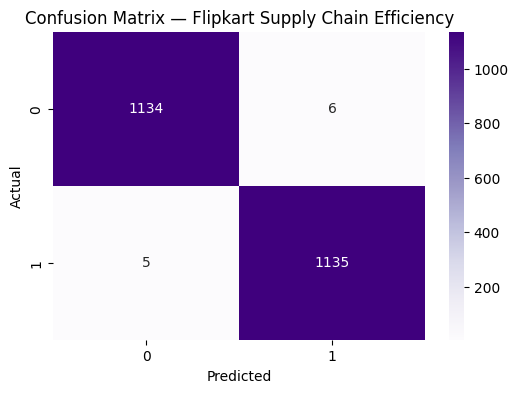

In [17]:
# -----------------------------#
# Step 7: Visualizations
# -----------------------------#
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix — Flipkart Supply Chain Efficiency")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

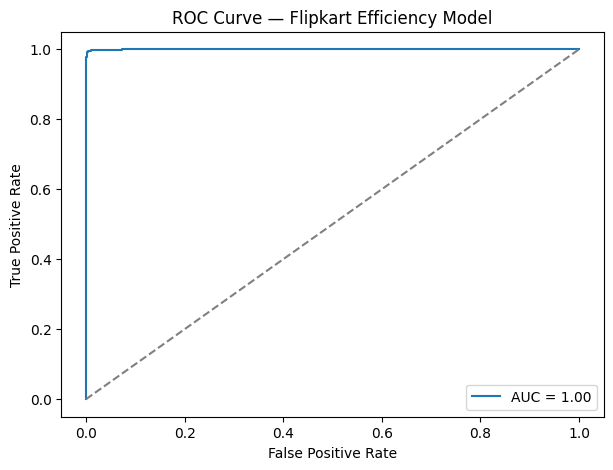

In [18]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("ROC Curve — Flipkart Efficiency Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [19]:
# -----------------------------#
# Step 8: Save Model, Scaler, Results
# -----------------------------#

model.save("results/Flipkart_DenseMLP_Model.h5")
joblib.dump(scaler, "results/Flipkart_Scaler.pkl")

['results/Flipkart_Scaler.pkl']

In [20]:
results = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "roc_auc": float(roc_auc),
    "total_records": len(data),
    "efficient_count": int(data['efficiency_label'].sum()),
    "inefficient_count": int(len(data) - data['efficiency_label'].sum())
}

In [21]:
with open("results/model_metrics_Flipkart.json", "w") as f:
    json.dump(results, f, indent=4)